<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/sdss_2pcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import scipy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

Install CAMB for theory prediction \\
Install KSTAT for making measurement

In [3]:
!pip install camb
!git clone https://github.com/csabiu/kstat.git

     |████████████████████████████████| 1.6 MB 5.4 MB/s 
  Created wheel for camb: filename=camb-1.3.2-py3-none-any.whl size=1009274 sha256=3c7acb9ca388d4863232f73370b8871636e04ffc0b081fad43be0a995d0e09c0
  Stored in directory: /root/.cache/pip/wheels/d3/c1/34/87632240be4218d112bc9b47c18e92ef81bfb6bc1e1f0f0a72
Successfully built camb
Cloning into 'kstat'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 0), reused 1 (delta 0), pack-reused 30
Unpacking objects: 100% (34/34), done.


Make KSTAT manually

In [45]:
output = os.system("cd kstat/src; make ; cd ../../")

2pcf*  3pcf*  3pcf_all*  3pcf_eq*


### Download SDSS eBOSS DR14 LRG data and random catalogs

In [48]:
!wget https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRG_clustering_random-NGC-vDR16.fits
!wget https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRG_clustering_data-NGC-vDR16.fits

--2021-10-27 01:51:38--  https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRG_clustering_random-NGC-vDR16.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349493760 (333M) [application/octet-stream]
Saving to: ‘eBOSS_LRG_clustering_random-NGC-vDR16.fits’

eBOSS_LRG_clusterin 100%[===================>] 333.30M  14.3MB/s    in 21s     

2021-10-27 01:51:59 (16.0 MB/s) - ‘eBOSS_LRG_clustering_random-NGC-vDR16.fits’ saved [349493760/349493760]

--2021-10-27 01:51:59--  https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRG_clustering_data-NGC-vDR16.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7747200 (7.4M) [application/octet-stream]
Sa

### Extract relavent columns from the fits file

In [49]:
hdul = fits.open('eBOSS_LRG_clustering_data-NGC-vDR16.fits')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wtot=hdul[1].data['WEIGHT_SYSTOT']
wcp=hdul[1].data['WEIGHT_CP']
wnoz=hdul[1].data['WEIGHT_NOZ']
wfkp=hdul[1].data['WEIGHT_FKP']
wgal=wtot*wcp*wnoz*wfkp #Eq 3 from https://arxiv.org/pdf/2007.09009.pdf

### Plot the redshift distribution

Text(0, 0.5, 'dN')

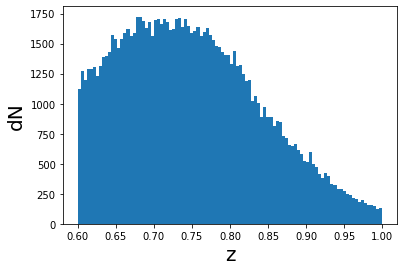

In [50]:
plt.hist(z,100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)

Text(0, 0.5, 'dec')

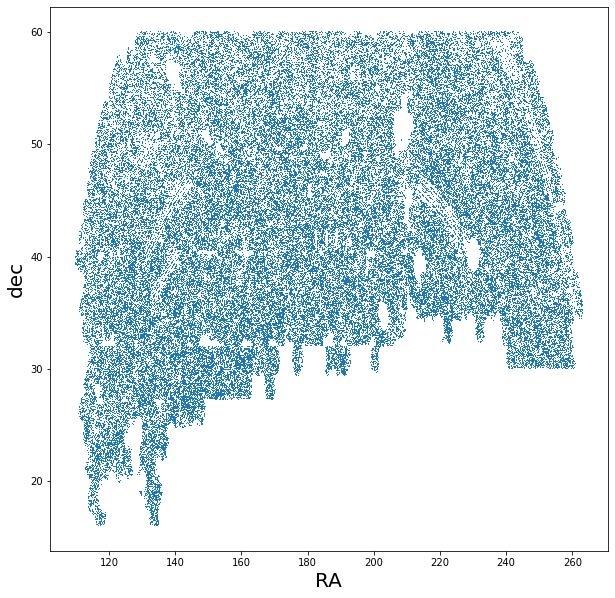

In [53]:
plt.figure(figsize=(10,10))
plt.plot(ra,dec,',')
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

## Use astropy to convert from angle and redshift to cartesean comoving x,y,z positions

In [54]:
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(Om0=0.31,Ob0=0.022,H0=100) # sets the cosmological model
dist=cosmo.comoving_distance(z).value  # convert redshift to distance

from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.Mpc) # convert to x,y,z
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wgal))
np.savetxt("gal.txt",data) # save file 

### Load the Random Catalogue and repeat the same proceedure 

In [55]:
hdul = fits.open('eBOSS_LRG_clustering_random-NGC-vDR16.fits')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wrand=hdul[1].data['WEIGHT_FKP']

Text(0, 0.5, 'dN')

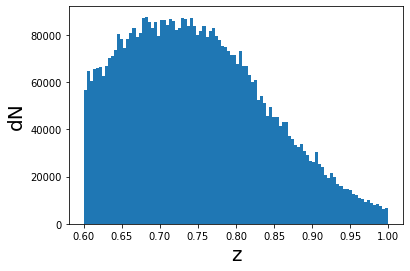

In [56]:
plt.hist(z,100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)


Text(0, 0.5, 'dec')

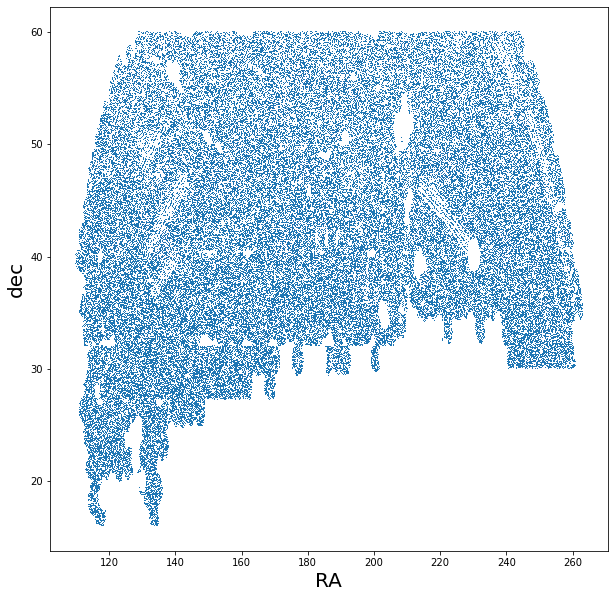

In [61]:
plt.figure(figsize=(10,10))
plt.plot(ra[::50],dec[::50],',') # plot a random sample
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

In [73]:
dist=cosmo.comoving_distance(z).value

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.Mpc)
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wrand))
np.savetxt("ran.txt",data[::10,:]) # save a subsample of data (1/30)

## Run my KSTAT code (few mins)

In [159]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -log .true. -wgt .true. 

 Using logarithmic binning scheme
 Using weighted points.
 Preparing to read       107500 data points
 Preparing to read       546072 random points
 opening gal.txt
 Finished reading data file 1
 opening ran.txt
 Finished reading data file 2
  building tree on node           0
  built tree on node           0
 Calculating the isotropic 3D correlation function
   1.0000000000000000        1.2271780044536826     
   1.2271780044536826        1.5059658546149226     
   1.5059658546149226        1.8480881722417255     
   1.8480881722417255        2.2679331552660544     
   2.2679331552660544        2.7831576837137404     
   2.7831576837137404        3.4154298923797612     
   3.4154298923797612        4.1913404396820519     
   4.1913404396820519        5.1435207967550411     
   5.1435207967550411        6.3120155872278669     
   6.3120155872278669        7.7459666924148340     
   7.7459666924148340        9.5056799481623280     
   9.5056799481623280        11.665161349761229     
  

Text(0, 0.5, '$\\xi$')

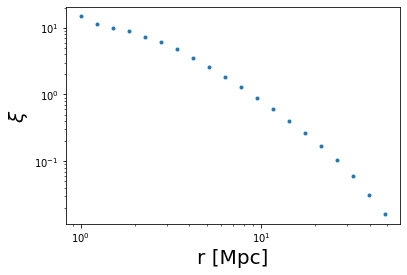

In [160]:
x=np.loadtxt('result.txt',skiprows=1)

plt.loglog(x[:,0],x[:,7],'.')
#plt.plot(x[:,0],x[:,7]*x[:,0]**2,'.')

plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

### Lets start to make the theory prediction with CAMB

In [76]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /usr/local/lib/python3.7/dist-packages/camb


### This is how you set up an instance of CAMB for the matter power spectrum with a particular cosmology 

In [161]:
#Set up a new set of parameters for CAMB
kmax=100          # maximum k range
k_per_logint = 5  # number of points per loh interval
zs = [0.7]        # redshift

pars = camb.CAMBparams()
pars.set_cosmology(H0=68.0, ombh2=0.022, omch2=0.12)
pars.InitPower.set_params(ns=0.965,As=2.0905e-09)
pars.WantTransfer = True
pars.set_matter_power(redshifts=zs, kmax=kmax, k_per_logint=k_per_logint, silent=True)
results = camb.get_results(pars)


PKint = results.get_matter_power_interpolator(nonlinear=True, 
    hubble_units=True, k_hunit=True,)

### Lets plot the power spectrum

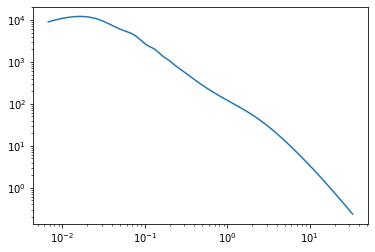

In [162]:
kh_nonlin=np.exp(np.arange(-5.0,3.5,0.0005))
pk_nonlin=PKint.P(0.7, kh_nonlin)
plt.loglog(kh_nonlin,pk_nonlin,'-')


Need to numerically integrate $$ \xi(r)=\frac{1}{2\pi^2}\int k^2P(k) J_0 dk$$

In [204]:
bias=1.8 #galaxy bias parameter

xi=[]
#rr=np.arange(10,200,10)
rr=np.arange(1,60,2)
for r in rr:
    xi.append(bias**2*np.trapz(kh_nonlin**2*pk_nonlin*np.sin(kh_nonlin*r)/(kh_nonlin*r),kh_nonlin)/(2*np.pi**2) )#+ 0.004)

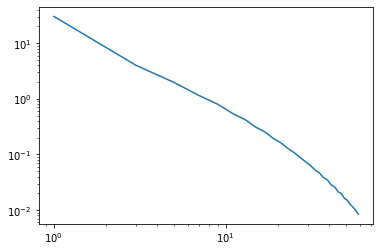

In [164]:
plt.loglog(rr,xi)
#plt.yscale('log')

### Plot the theory and data together

Text(0, 0.5, '$\\xi$')

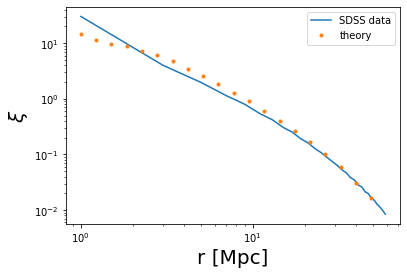

In [165]:
x=np.loadtxt("result.txt",skiprows=1)
#plt.plot(rr,xi*rr*rr,'-')
#plt.plot(np.mean(x[:,0:1],axis=1),x[:,7]*np.mean(x[:,0:1],axis=1)**2,'.')

plt.loglog(rr,xi,'-',label='SDSS data')
plt.loglog(np.mean(x[:,0:1],axis=1),x[:,7],'.',label='theory')

plt.legend()
plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

### Anisotropic Analysis
Use the kaiser formula \\
$$ P^s_g(k,\mu)= P^r_m(k)( b_g +f\mu^2)^2$$

In [220]:
ff=1.1   # growth
bias=1.5 # galaxy bias

pk_ani=np.zeros((60,60))

for i in range(1,60):    #1->60 Mpc sigma-pi
  for j in range(1,60):
    rr=np.sqrt(i**2+j**2)
    mu=j/rr
    pk=pk_nonlin*(bias+ff*mu**2)**2
    pk_ani[i,j]=np.trapz(kh_nonlin**2*pk*np.sin(kh_nonlin*rr)/(kh_nonlin*rr),kh_nonlin)/(2*np.pi**2)

Plot the anisotropic theory

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '$\\pi$ [Mpc/h]')

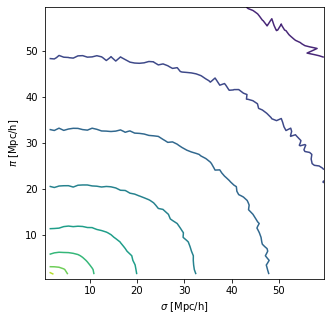

In [223]:
plt.figure(figsize=(5,5))
plt.contour(np.log10(pk_ani),origin='lower')
plt.xlabel(r'$\sigma$ [Mpc/h]',fontsize=10)
plt.ylabel(r'$\pi$ [Mpc/h]',fontsize=10)

### Run KSTAT with the anisotropic options

In [169]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -wgt .true. -iso ANISO -decp SIGPI

 Using weighted points.
 Preparing to read       107500 data points
 Preparing to read       546072 random points
 opening gal.txt
 Finished reading data file 1
 opening ran.txt
 Finished reading data file 2
  building tree on node           0
  built tree on node           0
 Calculating the anisotropic correlation function decomposed into sigma-pi
   1.0000000000000000        3.9500000000000002     
   3.9500000000000002        6.9000000000000004     
   6.9000000000000004        9.8500000000000014     
   9.8500000000000014        12.800000000000001     
   12.800000000000001        15.750000000000000     
   15.750000000000000        18.700000000000003     
   18.700000000000003        21.650000000000002     
   21.650000000000002        24.600000000000001     
   24.600000000000001        27.550000000000001     
   27.550000000000001        30.500000000000000     
   30.500000000000000        33.450000000000003     
   33.450000000000003        36.400000000000006     
   36.400000

In [207]:
x=np.loadtxt("result.txt",skiprows=1)
sig=np.mean(x[:,0:2],axis=1).reshape((20,20))
pi=np.mean(x[:,2:4],axis=1).reshape((20,20))
xi=x[:,9].reshape((20,20)).transpose()

### Plot the theory and data together

Text(0, 0.5, '$\\pi$ [Mpc/h]')

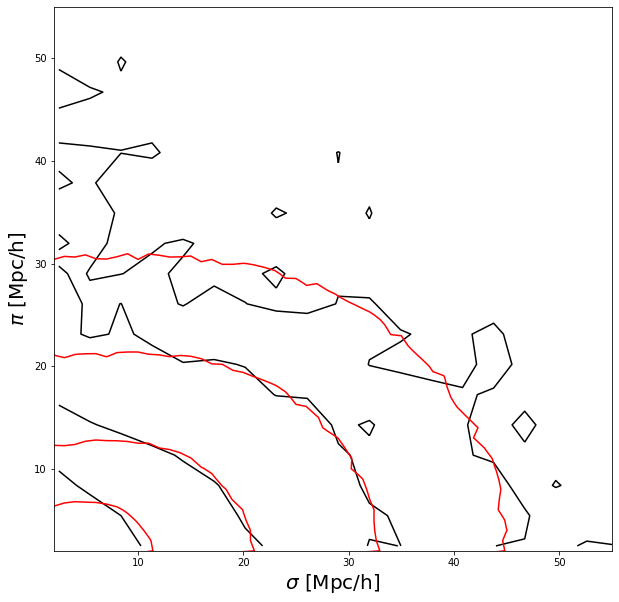

In [224]:
plt.figure(figsize=(10,10))
plt.contour(pi,sig,(xi),levels=[0.04, 0.1,0.3,1], colors='k')
plt.contour(range(1,61),range(1,61),(pk_ani),levels=[0.04, 0.1,0.3,1], colors='r')
plt.xlim((2,55))
plt.ylim((2,55))
plt.xlabel(r'$\sigma$ [Mpc/h]',fontsize=20)
plt.ylabel(r'$\pi$ [Mpc/h]',fontsize=20)

Large Scale and BAO

In [ ]:
x=np.loadtxt("result.txt",skiprows=1)
plt.plot(rr,xi*rr*rr,'-')
plt.errorbar(np.mean(x[:,0:1],axis=1),x[:,7]*np.mean(x[:,0:1],axis=1)**2,yerr=0.1*x[:,7]*np.mean(x[:,0:1],axis=1)**2,marker='.',ls='none')

plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)